In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, zipfile, shutil


ZIP_PATH = "/content/drive/MyDrive/Music_Dataset_Final.zip"
LOCAL_DATA_DIR = "/content/Music_Dataset_Final"

# Clean previous extraction
if os.path.exists(LOCAL_DATA_DIR):
    shutil.rmtree(LOCAL_DATA_DIR)

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(LOCAL_DATA_DIR)

print("Extracted to:", LOCAL_DATA_DIR)


import glob
meta_candidates = glob.glob(LOCAL_DATA_DIR + "/**/metadata.csv", recursive=True)
print("metadata.csv candidates:", meta_candidates[:5])
assert len(meta_candidates) > 0, "metadata.csv not found after unzip"


METADATA = meta_candidates[0]
AUDIO_ROOT = os.path.dirname(METADATA)
print("AUDIO_ROOT:", AUDIO_ROOT)
print("METADATA:", METADATA)


print("Folders:", [d for d in os.listdir(AUDIO_ROOT) if os.path.isdir(os.path.join(AUDIO_ROOT,d))][:20])


Mounted at /content/drive
Extracted to: /content/Music_Dataset_Final
metadata.csv candidates: ['/content/Music_Dataset_Final/metadata.csv']
AUDIO_ROOT: /content/Music_Dataset_Final
METADATA: /content/Music_Dataset_Final/metadata.csv
Folders: ['rock_metal_clips', 'hiphop_clips', 'jazz_clips', 'pop_clips']


In [ ]:
!pip -q install librosa umap-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
import umap

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


**Reproducibility helpers + metrics helpers**

[Reproducibility + Clustering Metrics (Silhouette/CH/DB/ARI/NMI/Purity)]

In [ ]:
import random, os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def cluster_purity(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    purity = 0
    n = len(y_true)
    for c in np.unique(y_pred):
        if c == -1:  # DBSCAN noise
            continue
        idx = np.where(y_pred == c)[0]
        if len(idx) == 0:
            continue
        purity += np.max(np.bincount(y_true[idx]))
    return purity / n if n > 0 else 0.0

def safe_silhouette(X, labels):
    labels = np.asarray(labels)
    X = np.asarray(X)
    # remove DBSCAN noise
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]
    if len(np.unique(y2)) < 2:
        return -1.0
    return float(silhouette_score(X2, y2))

def evaluate_all_metrics(X, y_pred, y_true=None):
    out = {}
    out["silhouette"] = safe_silhouette(X, y_pred)
    # CH/DB require >=2 clusters (excluding noise for DBSCAN)
    labels = np.asarray(y_pred)
    mask = labels != -1
    if len(np.unique(labels[mask])) >= 2:
        out["calinski_harabasz"] = float(calinski_harabasz_score(X[mask], labels[mask]))
        out["davies_bouldin"] = float(davies_bouldin_score(X[mask], labels[mask]))
    else:
        out["calinski_harabasz"] = -1.0
        out["davies_bouldin"] = -1.0

    if y_true is not None:
        y_true = np.asarray(y_true).astype(int)
        out["ari"] = float(adjusted_rand_score(y_true, y_pred))
        out["nmi"] = float(normalized_mutual_info_score(y_true, y_pred))
        out["purity"] = float(cluster_purity(y_true, y_pred))
    return out


**Dataset loading + label encoding + path resolver**

In [ ]:
df = pd.read_csv(METADATA)
print(df.head())
print("Total samples:", len(df))
print("Genre counts:\n", df["genre"].value_counts())

def normalize_genre(g):
    return str(g).strip().lower().replace(" ", "_")


folder_map = {
    "hiphop": "hiphop_clips",
    "rock_metal": "rock_metal_clips",
    "pop": "pop_clips",
    "jazz": "jazz_clips",
}

df["genre_norm"] = df["genre"].apply(normalize_genre)
df["folder"] = df["genre_norm"].map(folder_map)
assert df["folder"].isna().sum() == 0, "Some genres don't match folder_map. Check metadata genre names."

def audio_path_for_row(row):
    return os.path.join(AUDIO_ROOT, row["folder"], row["clip_name"])

# Strict check: fail early if anything missing
missing = 0
for i, row in df.iterrows():
    p = audio_path_for_row(row)
    if not os.path.exists(p):
        missing += 1
        if missing <= 10:
            print("Missing:", p)
print("Total missing files:", missing)
assert missing == 0, "Fix missing paths before proceeding (full-marks strictness)."

# Encode genre labels (used as "partial labels available" metrics)
genres = df["genre_norm"].astype("category")
y_true = genres.cat.codes.values
genre_names = list(genres.cat.categories)
num_clusters = len(genre_names)
print("num_clusters:", num_clusters, "genre_names:", genre_names)


                                clip_name  \
0  Eminem - Lose Yourself [HD]_part_1.mp3   
1  Eminem - Lose Yourself [HD]_part_2.mp3   
2  Eminem - Lose Yourself [HD]_part_3.mp3   
3  Eminem - Lose Yourself [HD]_part_4.mp3   
4  Eminem - Lose Yourself [HD]_part_5.mp3   

                                              lyrics   genre  
0                                                NaN  hiphop  
1                       Look, if you head, one shot.  hiphop  
2  I won't opportunity I see everything you ever ...  hiphop  
3  But on the surface he looks calm and ready to ...  hiphop  
4  He's so mad but he won't give up that he's he ...  hiphop  
Total samples: 3368
Genre counts:
 genre
rock metal    1068
hiphop        1000
jazz           688
pop            612
Name: count, dtype: int64
Total missing files: 0
num_clusters: 4 genre_names: ['hiphop', 'jazz', 'pop', 'rock_metal']


**Audio Feature Extraction (MFCC)**

In [ ]:
def extract_mfcc(audio_path, sr=22050, n_mfcc=40):
    y, _sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1).astype(np.float32)

X_mfcc = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    X_mfcc.append(extract_mfcc(audio_path_for_row(row)))

X_mfcc = np.stack(X_mfcc, axis=0)
print("X_mfcc:", X_mfcc.shape)

scaler = StandardScaler()
X = scaler.fit_transform(X_mfcc).astype(np.float32)


100%|██████████| 3368/3368 [06:46<00:00,  8.28it/s]


X_mfcc: (3368, 40)


**Define Basic VAE (MLP)**

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.fc2 = nn.Linear(latent_dim, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon = F.mse_loss(recon_x, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl


**Train VAE (GPU)**

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

model = VAE(input_dim=X.shape[1], latent_dim=16).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 300
model.train()
for ep in range(1, epochs+1):
    total = 0
    for (xb,) in loader:
        xb = xb.to(device)
        opt.zero_grad()
        recon, mu, logvar = model(xb)
        loss = vae_loss(recon, xb, mu, logvar)
        loss.backward()
        opt.step()
        total += loss.item()
    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep}/{epochs} loss={total/len(X):.4f}")

model.eval()
with torch.no_grad():
    mu, _ = model.encode(X_tensor.to(device))
    Z = mu.cpu().numpy()
print("Latent Z:", Z.shape)


Epoch 1/300 loss=39.3551
Epoch 10/300 loss=26.2591
Epoch 20/300 loss=24.6715
Epoch 30/300 loss=24.0683
Epoch 40/300 loss=23.7546
Epoch 50/300 loss=23.6014
Epoch 60/300 loss=23.4805
Epoch 70/300 loss=23.2773
Epoch 80/300 loss=23.1759
Epoch 90/300 loss=23.0565
Epoch 100/300 loss=22.9876
Epoch 110/300 loss=23.0344
Epoch 120/300 loss=22.8700
Epoch 130/300 loss=22.7925
Epoch 140/300 loss=22.6933
Epoch 150/300 loss=22.6947
Epoch 160/300 loss=22.6502
Epoch 170/300 loss=22.6148
Epoch 180/300 loss=22.7027
Epoch 190/300 loss=22.5813
Epoch 200/300 loss=22.5837
Epoch 210/300 loss=22.5934
Epoch 220/300 loss=22.4778
Epoch 230/300 loss=22.4777
Epoch 240/300 loss=22.3984
Epoch 250/300 loss=22.4119
Epoch 260/300 loss=22.3429
Epoch 270/300 loss=22.3197
Epoch 280/300 loss=22.3854
Epoch 290/300 loss=22.3333
Epoch 300/300 loss=22.4108
Latent Z: (3368, 16)


**Clustering on Latent (KMeans)**

In [ ]:
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
pred = kmeans.fit_predict(Z)

metrics_vae = evaluate_all_metrics(Z, pred)
print("VAE+KMeans metrics:", metrics_vae)


VAE+KMeans metrics: {'silhouette': 0.07046784460544586, 'calinski_harabasz': 214.43438720703125, 'davies_bouldin': 2.8198199280210203}


**Baseline: PCA + KMeans (Compare Silhouette & CH)**

In [ ]:
pca = PCA(n_components=16, random_state=42)
Z_pca = pca.fit_transform(X)

pred_pca = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(Z_pca)
metrics_pca = evaluate_all_metrics(Z_pca, pred_pca)

print("PCA+KMeans metrics:", metrics_pca)

pd.DataFrame([
    {"method":"VAE+KMeans", **metrics_vae},
    {"method":"PCA+KMeans", **metrics_pca},
])


PCA+KMeans metrics: {'silhouette': 0.11885011941194534, 'calinski_harabasz': 402.1054992675781, 'davies_bouldin': 2.3752725913273998}


,method,silhouette,calinski_harabasz,davies_bouldin
0,VAE+KMeans,0.070468,214.434387,2.819820
1,PCA+KMeans,0.118850,402.105499,2.375273


**Visualization: t-SNE or UMAP**

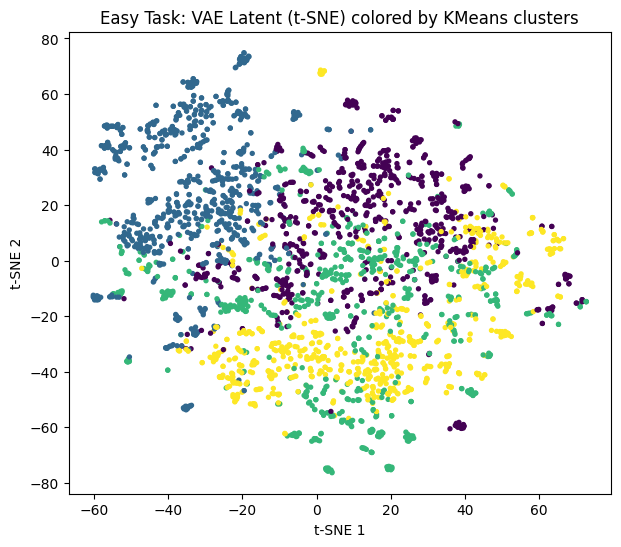

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


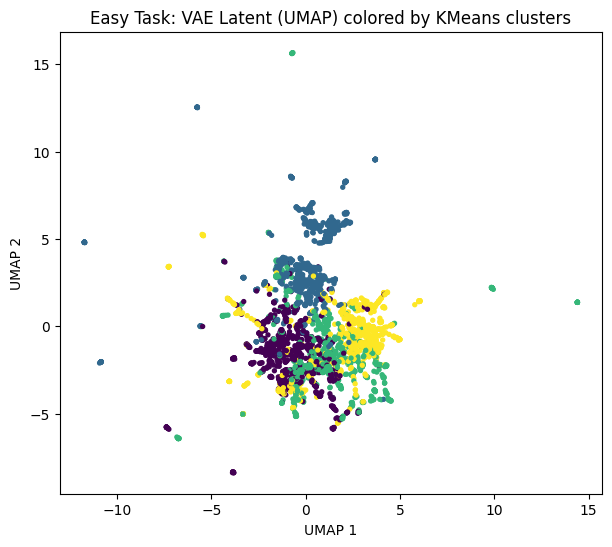

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Z_2d = tsne.fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], c=pred, s=8)
plt.title("Easy Task: VAE Latent (t-SNE) colored by KMeans clusters")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.show()

# Optional: UMAP
um = umap.UMAP(n_components=2, random_state=42)
Z_um = um.fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(Z_um[:,0], Z_um[:,1], c=pred, s=8)
plt.title("Easy Task: VAE Latent (UMAP) colored by KMeans clusters")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.show()


**Save Easy Task Outputs (latents, labels, metrics, plots)**

In [ ]:
import os, json

OUT_DIR = "/content/results_easy"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Save arrays needed for later comparisons
np.save(os.path.join(OUT_DIR, "X_mfcc.npy"), X_mfcc)
np.save(os.path.join(OUT_DIR, "X_mfcc_scaled.npy"), X)

np.save(os.path.join(OUT_DIR, "Z_vae.npy"), Z)
np.save(os.path.join(OUT_DIR, "clusters_vae_kmeans.npy"), pred)

np.save(os.path.join(OUT_DIR, "Z_pca.npy"), Z_pca)
np.save(os.path.join(OUT_DIR, "clusters_pca_kmeans.npy"), pred_pca)


np.save(os.path.join(OUT_DIR, "y_true.npy"), y_true)
with open(os.path.join(OUT_DIR, "genre_names.json"), "w") as f:
    json.dump(genre_names, f)

# 2) Save metrics table
metrics_df = pd.DataFrame([
    {"method":"Easy_VAE+KMeans", **metrics_vae},
    {"method":"Easy_PCA+KMeans", **metrics_pca},
])
metrics_df.to_csv(os.path.join(OUT_DIR, "easy_metrics.csv"), index=False)

print("Saved outputs to:", OUT_DIR)
metrics_df


Saved outputs to: /content/results_easy


,method,silhouette,calinski_harabasz,davies_bouldin
0,Easy_VAE+KMeans,0.070468,214.434387,2.819820
1,Easy_PCA+KMeans,0.118850,402.105499,2.375273


In [ ]:
SRC_DIR = "/content/results_easy"
ZIP_PATH = "/content/results_easy.zip"

# Remove old zip if it exists
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

# Create zip
shutil.make_archive(
    base_name=ZIP_PATH.replace(".zip", ""),
    format="zip",
    root_dir=SRC_DIR
)

print("ZIP created at:", ZIP_PATH)

from google.colab import files

files.download("/content/results_easy.zip")

ZIP created at: /content/results_easy.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>